In [1]:
from scripts.utils import *
from scripts.new_model import *
import matplotlib.pyplot as plt

In [2]:
with open('data/schizo_genes_filtered.txt', 'r') as file:
    genes = [line.strip() for line in file]

In [3]:
with open("genept/GenePT_gene_embedding_ada_text.pickle", "rb") as f:
    embedding_dict = pickle.load(f)


In [4]:
from sklearn.decomposition import PCA
import numpy as np

# Convert embeddings to a numpy array
embeddings_matrix = np.array([embedding_dict[gene] for gene in genes if gene in embedding_dict])

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(embeddings_matrix)

# Print or visualize the results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)


Explained variance ratio: [0.04842688 0.03937585]
Principal components shape: (324, 2)


Variance explained by each component: [0.04842688 0.03937585]


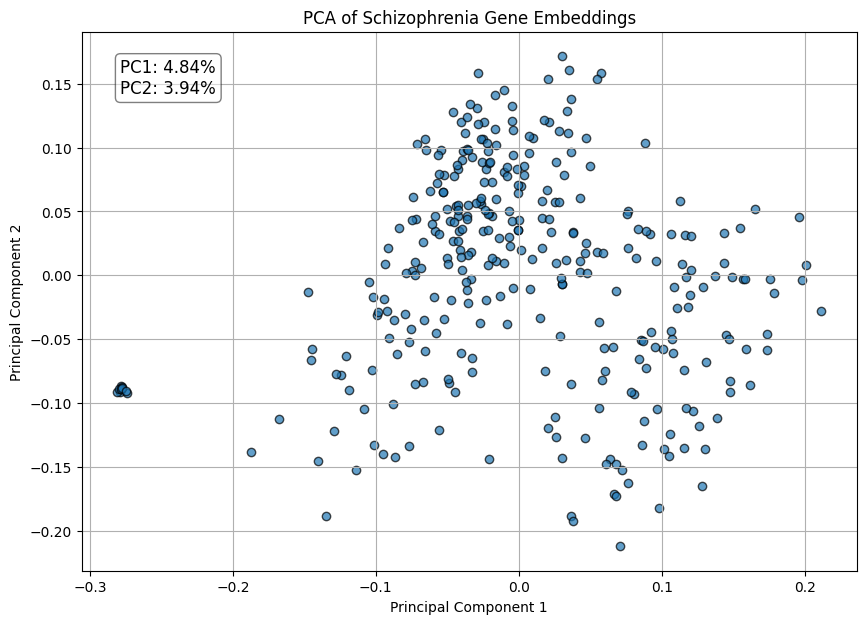

In [9]:
# Print the variance each principal component explains
print("Variance explained by each component:", pca.explained_variance_ratio_)

# Annotate the variance explained on the graph
variance_explained = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 7))
plt.text(0.05, 0.95, f"PC1: {variance_explained[0]:.2f}%\nPC2: {variance_explained[1]:.2f}%", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7, edgecolors='k')
plt.title('PCA of Schizophrenia Gene Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [6]:

model = MLP(input_dim=3072, hidden_dim=256)
model.load_state_dict(torch.load("models/mlp_epistasis.pt"))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

gene1 = genes[0]
gene2 = genes[324]

predict_epistatic(model, gene1, gene2, embedding_dict)

0.03930669277906418

In [10]:
from itertools import combinations
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

def plot_all_gene_combos_distance_vs_prediction(genes, model, embedding_dict):
    filtered_genes = [gene for gene in genes if gene in embedding_dict]
    embeddings_matrix = np.array([embedding_dict[gene] for gene in filtered_genes])
    pca = PCA(n_components=2)  # Reduce to 2 principal components
    principal_components = pca.fit_transform(embeddings_matrix)

    distances = []
    prediction_scores = []
    gene_pairs = []

    device = torch.device("cpu")
    model.to(device)    

    # Iterate over all combinations of gene pairs
    for gene1, gene2 in combinations(filtered_genes, 2):
        if gene1 in embedding_dict and gene2 in embedding_dict:
            if gene1 != gene2:
                # Get the PCA coordinates of the two genes
                gene1_pca = principal_components[filtered_genes.index(gene1)]
                gene2_pca = principal_components[filtered_genes.index(gene2)]

                # Calculate the Euclidean distance between the two genes in PCA space
                distance = euclidean(gene1_pca, gene2_pca)

                # Predict the epistatic interaction score using the model
                gene1_embedding = embedding_dict[gene1]
                gene2_embedding = embedding_dict[gene2]
                input_vector = np.concatenate([gene1_embedding, gene2_embedding]).reshape(1, -1)
                prediction_score = model(torch.tensor(input_vector, dtype=torch.float32)).item()

                # Store the results
                distances.append(distance)
                prediction_scores.append(prediction_score)
                gene_pairs.append((gene1, gene2))

    # Plot the distance vs prediction score
    plt.figure(figsize=(10, 7))
    plt.scatter(distances, prediction_scores, alpha=0.7, color='blue', label='Data points')

    # Add a regression line
    slope, intercept, r_value, p_value, std_err = linregress(distances, prediction_scores)
    regression_line = [slope * x + intercept for x in distances]
    plt.plot(distances, regression_line, color='red', label=f'Regression line (R²={r_value**2:.2f})')

    plt.title('Distance vs Prediction Score for All Gene Pairs')
    plt.xlabel('Distance in PCA Space')
    plt.ylabel('Prediction Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return distances, prediction_scores, gene_pairs

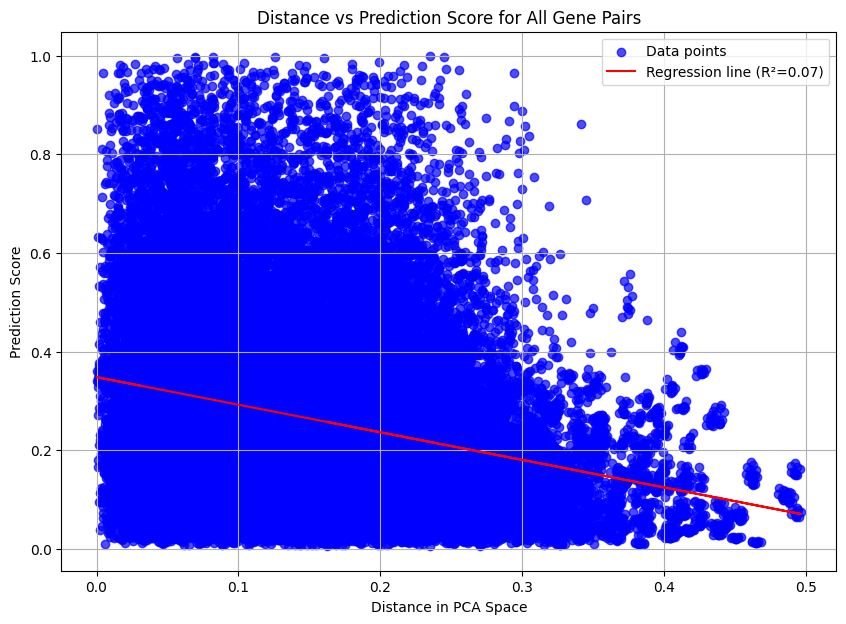

([0.163250023903253,
  0.22897734692023278,
  0.1594798815773066,
  0.21494813690189754,
  0.17707714354423318,
  0.1277832798332972,
  0.17698937509408388,
  0.13166127021390414,
  0.15163225882642342,
  0.19423141397278337,
  0.05488405652680647,
  0.1256478443801803,
  0.13896576507539318,
  0.16385048304845753,
  0.23077395059891567,
  0.192099152437128,
  0.15736077913623603,
  0.15287842232007842,
  0.05292356552923557,
  0.16816799309740435,
  0.10714488863945952,
  0.175795523730693,
  0.18659527754328112,
  0.19274162285489882,
  0.26862378170652434,
  0.15756111607588535,
  0.023528254792638172,
  0.09627891457132769,
  0.1324445838273017,
  0.16344544423106186,
  0.10495673059096576,
  0.13660849280542062,
  0.09448332933548033,
  0.18348399167996482,
  0.19736721772588856,
  0.1453615739659619,
  0.13791697442287754,
  0.08544011773579069,
  0.05124121640605652,
  0.057622951811206954,
  0.05780058207594584,
  0.05212608607360479,
  0.12496197131379508,
  0.1206154366410053

In [12]:
plot_all_gene_combos_distance_vs_prediction(genes, model, embedding_dict)

In [13]:
schizo_graph = load_graph("graphs/schizo_graph.gml")

In [65]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Assuming `existing_edges` is a list of edges already in the graph
existing_edges = set(schizo_graph.edges())

# Predicted edges
predicted_edges = set()

# Filter the genes to only those present in the embedding dictionary
filtered_genes = [gene for gene in genes if gene in embedding_dict]

# Iterate over all combinations of gene pairs
for gene1, gene2 in combinations(filtered_genes, 2):
    if gene1 == gene2:
        continue  # Skip self-loops

    # Get embeddings for the gene pair
    gene1_embedding = embedding_dict[gene1]
    gene2_embedding = embedding_dict[gene2]
    input_vector = np.concatenate([gene1_embedding, gene2_embedding]).reshape(1, -1)

    # Predict the epistatic interaction score
    prediction_score = model(torch.tensor(input_vector, dtype=torch.float32)).item()

    # Add an edge if the prediction score is above 0.9
    if prediction_score > 0.7:
        predicted_edges.add((gene1, gene2))
        if (gene1, gene2) not in existing_edges or (gene2, gene1) not in existing_edges:
            schizo_graph.add_edge(gene1, gene2, weight=prediction_score, color=0)
        

# Print the number of edges added
print(f"Pred: {len(predicted_edges)}")
print(f"Existing: {len(existing_edges)}")

Pred: 1821
Existing: 1552


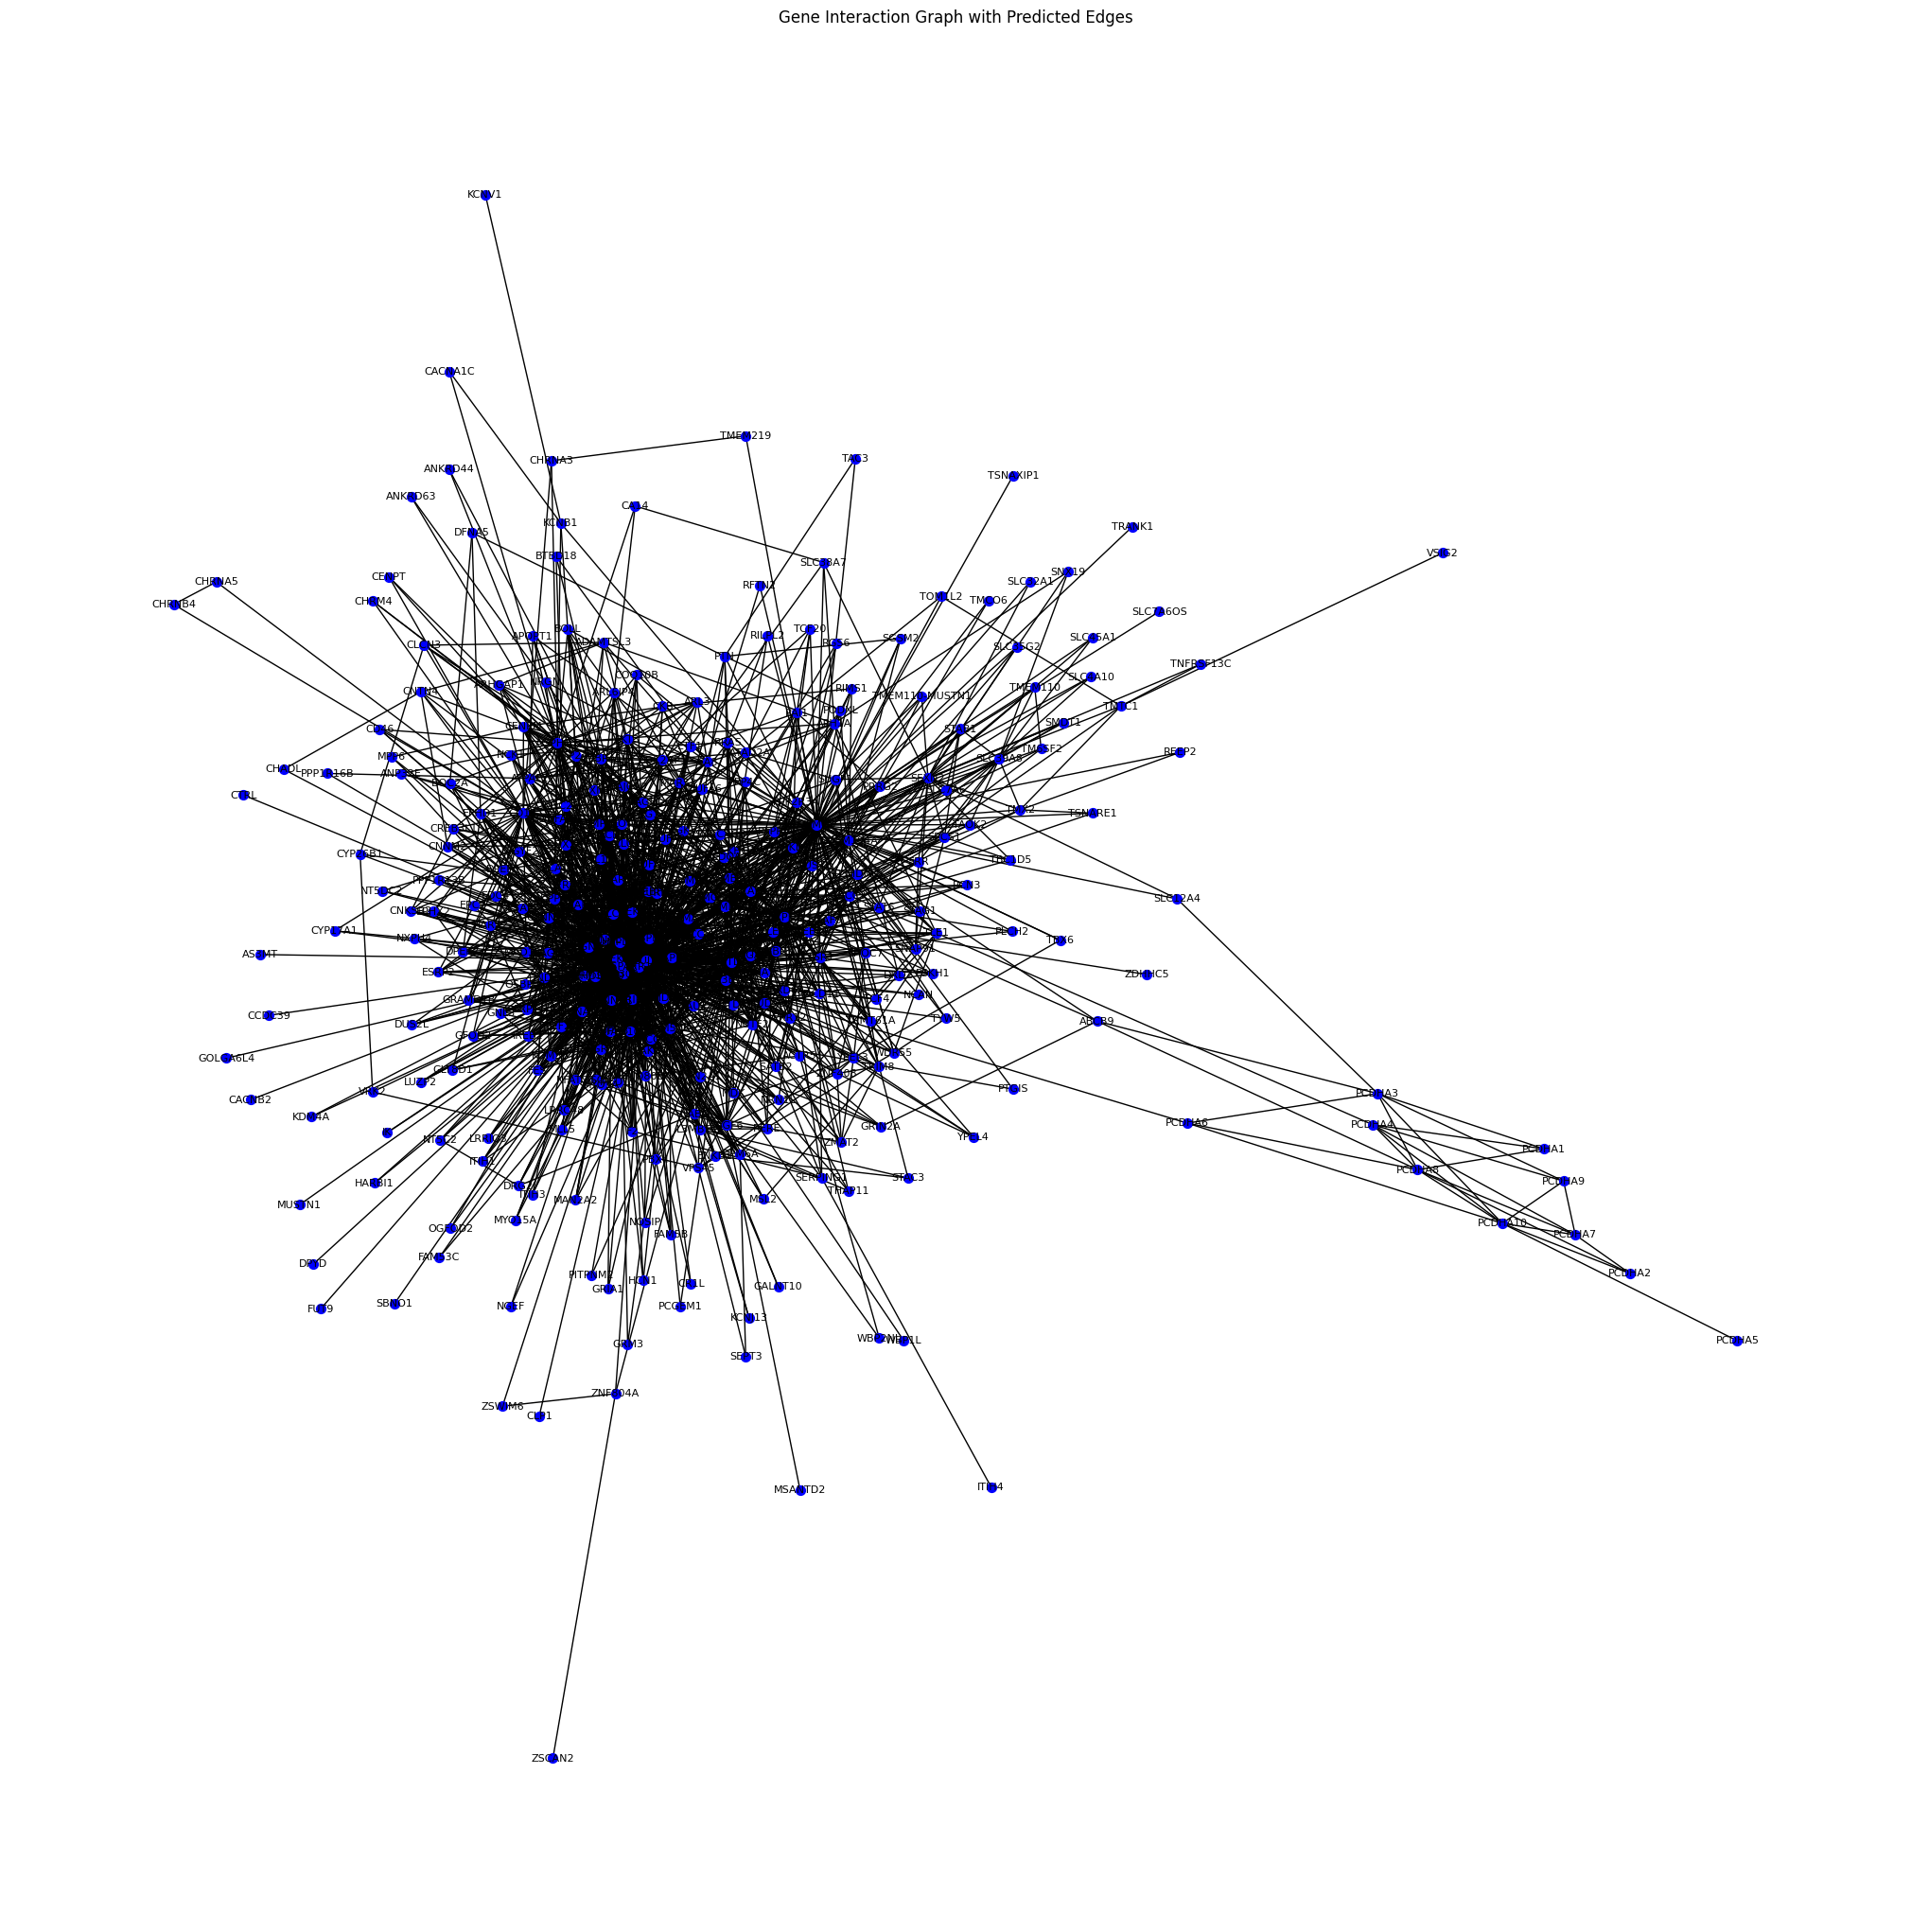

In [67]:
# I want to display the graph
plot_graph(schizo_graph, title="Gene Interaction Graph with Predicted Edges")

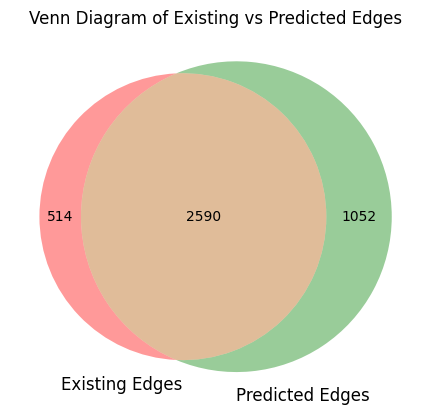

In [66]:
# Create a Venn diagram
# Add edges both directions for example if (gene1, gene2) is in existing_edges, add (gene2, gene1) too
bi_existing_edges = existing_edges | {(gene2, gene1) for gene1, gene2 in existing_edges}
bi_predicted_edges = predicted_edges | {(gene2, gene1) for gene1, gene2 in predicted_edges}

venn2([bi_existing_edges, bi_predicted_edges], ('Existing Edges', 'Predicted Edges'))
plt.title("Venn Diagram of Existing vs Predicted Edges")
plt.show()


In [68]:
predicted_not_in_existing = predicted_edges - existing_edges


In [71]:
predicted_not_in_existing

with open("graphs/predicted_not_in_existing.txt", "w") as f:
    for edge in predicted_not_in_existing:
        f.write(f"{edge[0]}\t{edge[1]}\n")